# **<span style="color: black; font-size:1em;">PrOMMiS LCA Integration: Environmental Life Cycle Assessment Using PrOMMiS Modeling Results</span>**

## <span style="color:black; font-weight:bold"> Introduction </span> 

<span style = "color:black">
This document demonstrates the application of Life Cycle Assessment (LCA) methodology to the optimized results from the PrOMMiS model.  
This Jupyter Notebook presents an example LCA application to the West Kentucky No.13 Coal Refuse Flowsheet optimized in the PrOMMiS model.
</br>

<u> Goal and Scope:</u> In this Jupyter Notebook, we use life cycle assessment to evaluate the environmental impact of Rare Earth Oxide Recovery from coal mining refuse.</br>
As shown in the system boundary below, the scope of this work starts with the leaching of size-reduced REE-rich feedstock (REE: Rare Earth Elements) and ends with the recovery of mixed REO solids. The process consists of six main stages: 1) Mixing and Leaching, 2) Rougher Solvent Extraction, 3) Cleaner Solvent Extraction, 4) Precipitation, 5) Solid-Liquid (S/L) separation, and 6) Roasting. </br>
It's crucial to note here that the current script does not account for:

* Upstream processes leading to the production of REE-rich feedstock 


* Downstream processes leading to the separation of REE contained in the REO    

<u> Main Product:</u> The main product of the flowsheet modeled in this Jupyter Notebook is Rare Earth Oxide (REO) solid.

<u> Co-products or by-products:</u> None

<u> Functional Unit:</u> The function unit is 1 kg of recovered REO solids

<u> Allocation:</u> The evaluated flowsheet produces a single product with no intermediate co-products or by-product. As a result, there is no need for allocation in this modeling exercise.

<u> Life cycle inventory Estimation:</u> The material and energy inputs shown in the system boundary figure below have been shortlisted and estimated based on the UKy flowsheet output, [technical reports on the production on the production of REE from coal and coal by-products](https://www.osti.gov/servlets/purl/1569277), and other relevant literature.
</span>

<span style = "color:black">

**Useful notes, definitions, and links:**
- **PrOMMiS model:** Process Optimization and Modeling for Minerals Sustainability initiative, led by the U.S. Department of Energy (DOE), specifically under NETL (National Energy Technology Laboratory). The PrOMMiS source code can be accessed on github through the following repository link: [https://github.com/prommis/prommis/tree/main](https://github.com/prommis/prommis/tree/main)<br> PrOMMiS serves to optimize processing flowsheets. This Jupyter Notebook focuses on a flowsheet for the extraction of REE from coal refuse. 


- **UKy Flowsheet Code:** [https://github.com/prommis/prommis/blob/main/src/prommis/uky/uky_flowsheet.py](https://github.com/prommis/prommis/blob/main/src/prommis/uky/uky_flowsheet.py)

</span>

<div style="text-align: center;">
    <img src="images/system_boundary_1.png" width="1000"/>
</div>

## <span style="color:black; font-weight:bold"> Step 1: Import the necessary tools </span> 

In [2]:
# import main libraries
import pandas as pd
import olca_schema as olca

from netlolca.NetlOlca import NetlOlca

import prommis.uky.uky_flowsheet as uky # module to run the PrOMMiS model
import src as lca_prommis

## <span style="color:black; font-weight:bold"> Step 2: Run PrOMMiS Optimization Model for the UKy flowsheet and extract model results  </span> 

<span style="color:black">  

In the next cell, the main() [function](https://github.com/prommis/prommis/blob/main/src/prommis/uky/uky_flowsheet.py#L255) runs the UKy flowsheet. This step includes:

* Building and connecting the unit model blocks present in the UKy REE processing plant.
* Setting the scaling factors
* Setting the operating conditions
* Initializing the values for all streams in the system
* Solving the system

This function returns a model object which is used to extract all the PrOMMiS results needed to estimate the flowsheet material and energy inputs.

The [get_lca_df()](https://github.com/KeyLogicLCA/lca-prommis/blob/main/src/prommis_LCA_data.py#L72) function extracts the main PrOMMiS results to calculate material and energy flows needed to develop a life cycle assessment model.
The inventory estimation is primarily based on the results reported by the PrOMMiS model with a few exceptions:
* The oxalic acid input rate is estimated based on the known input of sulfuric acid, and applying the ratio of Oxalic acid to sulfuric acid as reported in the literature for similar processes.
* Reducing agent and caustic solution inputs are reported in [similar flowsheets](https://www.osti.gov/servlets/purl/1569277) for the solvent extraction stages. However, the input amounts are not reported in the UKy flowsheet in PrOMMiS, and as such are omitted in this analysis due to the lack of data and information to estimate them. 
</br>

</span>

In [3]:
# Run UKy flowsheet, and get prommis model
m, _ = uky.main() 

# Extract LCA data
prommis_data = lca_prommis.data_lca.get_lca_df(m)
prommis_data.to_csv("output/lca_df.csv")

2025-09-30 14:02:56 [INFO] idaes.prommis.uky.uky_flowsheet: Initialization Order: {_init_ord}
INFO Initialization Order: {_init_ord}
INFO Starting Sequential Decomposition
INFO Starting first pass run of network
2025-09-30 14:02:56 [INFO] idaes.prommis.uky.uky_flowsheet: Initializing fs.leach_solid_feed
INFO Initializing fs.leach_solid_feed
2025-09-30 14:02:56 [INFO] idaes.prommis.uky.uky_flowsheet: Initializing fs.leach_liquid_feed
INFO Initializing fs.leach_liquid_feed
2025-09-30 14:02:56 [INFO] idaes.prommis.uky.uky_flowsheet: Initializing fs.solex_rougher_load
INFO Initializing fs.solex_rougher_load
2025-09-30 14:02:57 [INFO] idaes.init.fs.solex_rougher_load.mscontactor: Stream Initialization Completed.
2025-09-30 14:02:57 [INFO] idaes.init.fs.solex_rougher_load.mscontactor: Initialization Completed, optimal - <undefined>
2025-09-30 14:02:57 [INFO] idaes.prommis.uky.uky_flowsheet: Initializing fs.rougher_org_make_up
INFO Initializing fs.rougher_org_make_up
2025-09-30 14:02:57 [INFO

## <span style="color:black; font-weight:bold"> Step 3: Review PrOMMiS Results </span> 

In [4]:
prommis_data.head()

,Flow,Source,In/Out,Category,Value 1,Unit 1,Value 2,Unit 2
0,Inerts,Solid Feed,In,Solid Input,22.68,kg/hr,0.6952,mass fraction
1,Scandium Oxide,Solid Feed,In,Solid Input,22.68,kg/hr,0.000028,mass fraction
2,Yttrium Oxide,Solid Feed,In,Solid Input,22.68,kg/hr,0.000033,mass fraction
3,Lanthanum Oxide,Solid Feed,In,Solid Input,22.68,kg/hr,0.000068,mass fraction
4,Cerium Oxide,Solid Feed,In,Solid Input,22.68,kg/hr,0.000156,mass fraction


## <span style="color:black; font-weight:bold"> Step 4: Organize, Categorize, and Covert PrOMMiS Results to LCA Relevant Flows </span> 

<span style = "color:black">

**Purpose:** This step converts the raw PrOMMiS model results into Life Cycle Assessment (LCA) relevant units.

The [convert_flows_to_lca_units()](https://github.com/KeyLogicLCA/lca-prommis/blob/main/src/prommis_LCA_conversions.py#L121) function processes the PrOMMiS data extracted in Step 2 and performs several key unit changes:

- Converts all flow rates and mass/mole fractions from the PrOMMiS model (which reports streams in kg/hr, mol/hr, etc. and components by mass or mole fraction) into equivalent quantities (e.g., mass or volume).
- Converts molar flows to mass flows using molecular weights when mol_to_kg=True using the pubchempy and pymatgen libraries
- Standardizes water flows to a specified unit (m3, L, or kg)

<u><b>Calculation example:</u></b> If the flow rate is 10 kg/hr and the mass fraction of 'Input 1' is 20%, the mass of 'Input 1' is calculated as 10*20/100 = <b>4.536 kg</b>. All the inventory is estimating on the basis of a 1-hour timestep.   

Key Parameters:

- ```hours=1```: Time period for conversion (1 hour based on PrOMMiS model timestep).</br> 
<u>Important note on timestep selection</u>: After converting values into LCA-relevant units, all emissions, as well as material and energy inputs, are normalized to the functional unit: in this case, 1 kg of REO product. This is done by dividing each input and emission by the amount of REO produced. In doing so, the influence of timestep selection is removed. Therefore, the chosen timestep has no impact on the final exchanges table used to build the openLCA model. 
- ```mol_to_kg=True```: Converts molar flows to mass flows using molecular weights
- ```water_unit='m3'```: Standardizes water flows to cubic meters. Other options are 'L' and 'kg' (kg may cause errors when assigning a unit in openLCA)

The function creates a new DataFrame with two additional columns:

- **LCA_Amount:** The amount for a flow in the new LCA unit
- **LCA_Unit:** The standardized unit for LCA modeling

This converted data is saved as ```output/lca_df_converted.csv```


</span>

In [5]:
# Hours is the time period for the conversion
# mol_to_kg is a boolean that indicates whether to convert moles to kg
# water_unit is the unit of water (m3 or L recommended, kg is also an option)
df = lca_prommis.convert_lca.convert_flows_to_lca_units(prommis_data, hours=1, mol_to_kg=True, water_unit='m3')
df.to_csv('output/lca_df_converted.csv', index=False)

# This will create a new datafrane and csv file that contains the initial prommis_data df with two additional columns:
# 'LCA Amount' and 'LCA Unit'

WARNING Dynamically registering the following numeric type:
    pymatgen.core.units.FloatWithUnit
Dynamic registration is supported for convenience, but there are known
limitations to this approach.  We recommend explicitly registering
numeric types using RegisterNumericType() or RegisterIntegerType().


## <span style="color:black; font-weight:bold"> Step 5: Normalize Flows to the Selected Functional Unit and Review Final LCA Flows </span> 

<span style = "color:black">

**Purpose:** This step transforms the converted PrOMMiS model results into a standardized format suitable for Life Cycle Assessment (LCA) modeling by normalizing flows into a functional unit, merging identical flows, and organizing the data according to LCA conventions.

This cell outlines the steps taken in the [main() function in finalize_LCA_flows.py](https://github.com/KeyLogicLCA/lca-prommis/blob/main/src/finalize_LCA_flows.py#L90). This code makes the following changes to the LCA data:

- Merges the following flows into single flows:
    - Merges the solid feed flows into a singular REO feed input flow
    - Merges the solid output flows into a singular REO product flow
    - Merges wastewater flows into a single flow for liquid waste
    - Merges solid waste flows into a single flow for solid waste
- Normalizes all flows based on the reference flow, 1 kg 73.4% REO Product
- Creates a new dataframe with columns matching openLCA format:
    - Adds a new *category* column for all flows
    - Adds new *context* and *UUID* columns for elementary flows using FEDEFL

This converted data is saved as ```output/lca_df_finalized.csv```


</span>

In [6]:
# The below code will normalize the converted prommis data to a functional unit
# Note: This code is developed for the UKy flowsheet and the functional unit is automatically set to 1 kg of REO (combination of all REEs)
# TODO: This code should be developed for the other flowsheets. To achieve this, the user should be able to specify the desired functional unit
df = pd.read_csv('output/lca_df_converted.csv')

# Run the merge_flows function for the feed
REO_list = [
    "Yttrium Oxide",
    "Lanthanum Oxide",
    "Cerium Oxide",
    "Praseodymium Oxide",
    "Neodymium Oxide",
    "Samarium Oxide",
    "Gadolinium Oxide",
    "Dysprosium Oxide",
]
df = lca_prommis.final_lca.merge_flows(df, merge_source='Solid Feed', new_flow_name='374 ppm REO Feed', value_2_merge=REO_list)
# This 374 ppm value is directly calculated from the flowsheet. The original study actually used 357 ppm as the feed concentration.

# Run the merge_flows function for the product
df = lca_prommis.final_lca.merge_flows(df, merge_source='Roaster Product', new_flow_name='73.4% REO Product')

# Run the merge_flows function for the liquid waste flows
df = lca_prommis.final_lca.merge_flows(df, merge_source='Wastewater', new_flow_name='Wastewater', merge_column='Category') 
# Note: some of these streams are organic waste, but they're treated as wastewater

# Run the merge_flows function for the solid waste flows
df = lca_prommis.final_lca.merge_flows(df, merge_source='Solid Waste', new_flow_name='Solid Waste', merge_column='Category') 

# Run the finalize_df function
try:
    finalized_df = lca_prommis.final_lca.finalize_df(
        df=df, 
        reference_flow='73.4% REO Product', 
        reference_source='Roaster Product',
        water_type='raw fresh water'
    )
    
    # Get summary
    summary = lca_prommis.final_lca.get_finalize_summary(finalized_df)
    print("Summary:")
    for key, value in summary.items():
        if key != 'flow_type_breakdown':
            print(f"  {key}: {value}")
    
    print("\nFlow Type Breakdown:")
    for flow_type, count in summary['flow_type_breakdown'].items():
        print(f"  {flow_type}: {count}")
        
except Exception as e:
    print(f"Error during finalization: {e}")

finalized_df.to_csv('output/lca_df_finalized.csv', index=False)
finalized_df.head(10)

Applied functional unit conversion with scaling factor: 2.1744429330020615e-05
Reference flow: 73.4% REO Product from Roaster Product
INFO Returning C:\Users\franc\AppData\Local\fedelemflowlist\FedElemFlowListMaster_v1.3.0_a79846d.parquet
Summary:
  total_flows: 18
  input_flows: 11
  output_flows: 7
  reference_products: 1
  unique_flow_types: 9
  total_lca_amount: 19016742.94134582

Flow Type Breakdown:
  Chemicals: 7
  Emissions to air: 4
  Solid Input: 1
  Solid Output: 1
  Electricity: 1
  Heat: 1
  Solid Waste: 1
  Wastewater: 1
  Water: 1


,Flow_Name,LCA_Amount,LCA_Unit,Is_Input,Reference_Product,Flow_Type,Category,Context,UUID,Description
0,374 ppm REO Feed,1.043143e+06,kg,True,False,Solid Input,Technosphere flows,,,
1,50% Caustic Solution,2.017326e+04,kg,True,False,Chemicals,Technosphere flows,,,
2,73.4% REO Product,1.000000e+00,kg,False,True,Solid Output,Technosphere flows,,,
3,Ascorbic Acid,1.650539e+03,kg,True,False,Chemicals,Technosphere flows,,,
4,Carbon dioxide,6.815915e-01,kg,False,False,Emissions to air,Elementary flows,emission/air,b6f010fb-a764-3063-af2d-bcb8309a97b7,
5,DEHPA,5.565504e+05,kg,True,False,Chemicals,Technosphere flows,,,
6,"Electricity, AC, 120 V",1.195654e+03,kWh,True,False,Electricity,Technosphere flows,,,
7,Hydrochloric Acid,2.756568e+03,kg,True,False,Chemicals,Technosphere flows,,,
8,Kerosene,4.676894e+05,kg,True,False,Chemicals,Technosphere flows,,,
9,Natural Gas,3.366081e+03,m3,True,False,Heat,Technosphere flows,,,


## <span style="color:black; font-weight:bold"> Step 6: Connect to openLCA </span> 

#### <span style="color:black; font-weight:bold"> Using this Jupyter Notebook with openLCA </span> 

<span style = "color:black">
In the following modeling stages, this Jupyter Notebook creates an openLCA process, converts it to a product system, and calculates the environmental impacts of the flowsheet described in the introduction.  
As a result, please follow these steps before proceeding to the next cell in this notebook:

* Open openLCA on your desktop, prefereable with a version > 2.50

* Download the PrOMMiS openLCA database from EDX (Next Cell). The PrOMMiS database contains all the processes and impact assessment methods needed to build and evaluate the UKy flowsheet in openLCA.

* Import and open the PrOMMiS openLCA database

* Connect to IPC server (Port 8080). Go to Tools > Developer Tools > IPC Server > Connect

</span>
 

#### <span style="color:black; font-weight:bold"> Download PrOMMiS Database from EDX </span> 

<span style = "color:black">
The cell below downloads the PrOMMiS openLCA database from EDX in JSONLD format and save it in a dedicated 'resources' folder in the current working directory. The following cell will require your EDX API key to download the requested database. Note that the resource ID is set in the next cell but it's advised to cross-check that the ID is correct. The database is constantly being improved and updated, and as a result can have a different resource ID.</br>

The PrOMMiS openLCA database includes:

* The life cycle assessment methods evaluating numerous categories including: water consumption, cumulative energy demand, global warming potential, and acidification potential.

* The background data needed to model the coal refuse flowsheet. This data was retrieved from open-source databases including: USLCI, NETL UP library, and literature. Noteworthy, some processes were unavailable in open-source databases and as a result were modeled and icnluded in the PrOMMiS openLCA database using the following approaches:</br>
    * <b><u>Oxalic Acid</b></u>: The inventory for oxalic was retrieved from ecoinvent v3.11 using the followig process: Oxalic acid {RoW}| oxalic acid production | Cut-off, S </br>
    * <b><u>Ascorbic Acid</b></u>: The inventory for oxalic was retrieved from ecoinvent v3.11 using the followig process: Ascorbic acid {GLO}| market for ascorbic acid | Cut-off, S</br>
    * <b><u>DEHPA</b></u>: The foreground data for DEHPA was retrieved from Cao et al.(2023). To model DEHPA using the literature foreground data, we used the following inventory from the ecoinvent database:</br>
        * <b><u>Acetaldehyde</b></u>:The inventory for acetaldehyde was retrieved from ecoinvent v3.11 using the followig process: Acetaldehyde {GLO}| market for acetaldehyde | Cut-off, S </br>
        * <b><u>Phosphorus oxychloride</b></u>: The inventory for phosphorus oxychloride was retrieved from ecoinvent v3.11 using the followig process: Phosphorus oxychloride {GLO}| market for phoshorus oxychloride | Cut-off, S </br>

<b><u>Sources</b></u>:</br>
[1] ecoinvent. (2024, November). ecoinvent version 3.11. Ecoinvent. 
[2] Yuanyu Cao, Liang Li, Ying Zhang, Zengwen Liu, Liqi Wang, Fan Wu, Jing You, Co-products recovery does not necessarily mitigate environmental and economic tradeoffs in lithium-ion battery recycling, Resources, Conservation and Recycling, Volume 188, 2023, 106689, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2022.106689.

To verify that you're using the correct resource ID, follow this link: [https:/edx.netl.doe.gov/workspace/resources/prommis-lca-integration](https:/edx.netl.doe.gov/workspace/resources/prommis-lca-integration) 
</span>
 

In [ ]:
# This is the resource ID of the PrOMMiS openLCA database as of September 30, 2025
resource_id = '1146b7de-ffca-4eec-9f0f-96e78488f52f'

# The function below downloads the database and saves it in a 'resources' folder in the current work directory
lca_prommis.import_db.import_db(resource_id)

#### <span style="color:black; font-weight:bold"> Connect to openLCA IPC Server </span> 

In [7]:
netl = NetlOlca()
netl.connect()
netl.read()

INFO Connected on http://localhost:8080
INFO Read UUIDs from IPC connection.


#### <span style="color:black; font-weight:bold"> Import Exchanges Table </span> 

<span style="color:black"> 
To create a process in openLCA we need to import the exchanges table generates in previous steps.
The exchanges table should have the following:

* <u> Flow Name:</u> this will be later used to guide you in creating exchanges
* <u>LCA Amount:</u> This is the amount normalized to 1 kg of the quantitative reference flow. In this case, it is the amount per kg REO product.
* <u>LCA Unit</u>
* <u>Is_input:</u> Determines whether the created exchange is an input or an output
* <u>Reference Product:</u> There should be one reference product. For example, in this case its the REO Product.
* <u>Flow Type</u>
* <u>Category:</u> Flows are labeled as Technosphere flows (referred to as product flows in openLCA), waste flows, and elementary flows.
* <u>Context:</u> Elementary flows are assigned a context such as: emission/air, emission/ground, resource/ground, etc.
* <u>UUID:</u> Since elementary flows should be assigned a FEDEFL compliant flow in openLCA, they are automatically assigned a UUID. The UUID is assigned based on matching flow name and context in the Federal Elementary Flow List.
* <u>Description</u>

</span>

In [8]:
# Save the LCA data produced in previous steps in a dataframe called df
df = pd.read_csv('output/lca_df_finalized.csv')
df.head(20)

,Flow_Name,LCA_Amount,LCA_Unit,Is_Input,Reference_Product,Flow_Type,Category,Context,UUID,Description
0,374 ppm REO Feed,1.043143e+06,kg,True,False,Solid Input,Technosphere flows,NaN,NaN,NaN
1,50% Caustic Solution,2.017326e+04,kg,True,False,Chemicals,Technosphere flows,NaN,NaN,NaN
2,73.4% REO Product,1.000000e+00,kg,False,True,Solid Output,Technosphere flows,NaN,NaN,NaN
3,Ascorbic Acid,1.650539e+03,kg,True,False,Chemicals,Technosphere flows,NaN,NaN,NaN
4,Carbon dioxide,6.815915e-01,kg,False,False,Emissions to air,Elementary flows,emission/air,b6f010fb-a764-3063-af2d-bcb8309a97b7,NaN
5,DEHPA,5.565504e+05,kg,True,False,Chemicals,Technosphere flows,NaN,NaN,NaN
6,"Electricity, AC, 120 V",1.195654e+03,kWh,True,False,Electricity,Technosphere flows,NaN,NaN,NaN
7,Hydrochloric Acid,2.756568e+03,kg,True,False,Chemicals,Technosphere flows,NaN,NaN,NaN
8,Kerosene,4.676894e+05,kg,True,False,Chemicals,Technosphere flows,NaN,NaN,NaN
9,Natural Gas,3.366081e+03,m3,True,False,Heat,Technosphere flows,NaN,NaN,NaN


#### <span style="color:black; font-weight:bold"> Enter Process Information </span> 

##### <span style="color:black; font-weight:bold"> Unit Process Name </span> 

In [9]:
process_name = input("Enter process name: ")  

Enter process name:  REO Extraction From Coal Mining Refuse | UKy Flowsheet


##### <span style="color:black; font-weight:bold"> Unit Process Description </span> 

In [10]:
process_description = input("Enter a process description: ")

Enter a process description:  This process involves the production of a Rare Earth Oxide solid extraction from coal mining refuse. The scope of this work starts with the leaching of size-reduced REE-rich feedstock (REE: Rare Earth Elements) and ends with the recovery of mixed REO solids. The process consists of six main stages: 1) Mixing and Leaching, 2) Rougher Solvent Extraction, 3) Cleaner Solvent Extraction, 4) Precipitation, 5) Solid-Liquid (S/L) separation, and 6) Roasting. This process does not account for upstream processes leading to the production of REE-rich feedstock nor does it account for Downstream processes leading to the separation of REE contained in the REO. The main product is a rare earth oxide solid with no other by-products or co-products. The functional unit is 1 kg of recovered REO solids. The material and energy inputs shown in the system boundary figure below have been shortlisted and estimated based on the UKy flowsheet output, as well as other relevant lite

##### <span style="color:black; font-weight:bold"> Create process with exchanges </span> 

<span style="color:black">  
In the next step, the function reads the exchanges table and examines each row:
</br>

* If the exchange is a reference product, the user can: 1) create an exchange using an existing flow in the PrOMMiS database or 2) create a new flow, create an exchange for it, and set it as a quantitative reference (e.g., reference product)
</br>

* If the exchange is an elementary flow, the function automatically creates an exchange for it using the given uuid.
</br>

* If the exchange is a technosphere or waste flow, the user has to select a flow and and provider in order to create an exchange, using the following sequence:
    1) Enter keyword to search for a flow
    2) Select a flow from a provided list. The function automatically creates a list of all providers generating this flow.
    3) Select a provider from the provided list.

    
</span>

In [11]:
### create process usign the create_new_process function
process = lca_prommis.create_lca.create_new_process(netl,df,process_name,process_description)
# get the process uuid to be used in the following step when create a product system
process_id = process.id
# NOTE: For future discussion - is it better to select the flow then the provider (current status) or pick provider first then select relevant flows?

Creating exchange database, this may take a couple minutes...


Creating exchange for product flow: 374 ppm REO Feed
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use 374 ppm REO Feed:  skip


Skipping flow: 374 ppm REO Feed


Creating exchange for product flow: 50% Caustic Solution
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use 50% Caustic Solution:  sodium hydroxide


Searching for flows containing 'sodium hydroxide'...
Found 5 flows matching 'sodium hydroxide'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: Sodium hydroxide; at plant | UUID: d12c4a32-12a8-4673-9b14-5d227d2a128e


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: Chlorine; chlor-alkali electrolysis; at plant | Process_UUID: a3e150d0-770e-4e2a-9b19-f7daa8cda38b
  2. Process_Name: Sodium hydroxide; chlor-alkali average, membrane cell; at plant; 50% solution state | Process_UUID: 344a7ac0-8c18-4869-bb63-3e44e811a1d9


Select a provider process (1-2 or 'q' to quit):  2


Selected process UUID: 344a7ac0-8c18-4869-bb63-3e44e811a1d9
Exchange created for product flow: 50% Caustic Solution


Creating exchange for reference product: 73.4% REO Product
----------------------------------------
Do you want to select an existing quantitative reference flow or create a new one?
1. Select existing flow
2. Create new flow


Enter your choice (1 or 2):  2


Created flow: 73.4% REO Product with ID: 059830d9-20b1-4d6d-916d-36354300ec1e


Creating exchange for product flow: Ascorbic Acid
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Ascorbic Acid:  


Searching for flows containing 'Ascorbic Acid'...
Found 1 flows matching 'Ascorbic Acid'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: Ascorbic acid {GLO}| market for ascorbic acid | Cut-off, S | UUID: 9af500ca-a4f2-37cf-90f4-c9b69b7df98c


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: Ascorbic acid {GLO}| market for ascorbic acid | Cut-off, S | Process_UUID: ae76d745-3286-399d-b746-8f7f2852837d


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: ae76d745-3286-399d-b746-8f7f2852837d
Exchange created for product flow: Ascorbic Acid


Creating exchange for elementary flow: Carbon dioxide
--------------------------------------
Exchange created for elementary flow: Carbon dioxide


Creating exchange for product flow: DEHPA
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use DEHPA:  


Searching for flows containing 'DEHPA'...
Found 1 flows matching 'DEHPA'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: DEHPA | UUID: 5fd5dd9b-1d46-431a-ad8e-c743ad94d2cc


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: DEHPA | Process_UUID: 1b73298f-0705-4d7a-9e6b-506fb58a50b3


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 1b73298f-0705-4d7a-9e6b-506fb58a50b3
Exchange created for product flow: DEHPA


Creating exchange for product flow: Electricity, AC, 120 V
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Electricity, AC, 120 V:  


Searching for flows containing 'Electricity, AC, 120 V'...
Found 1 flows matching 'Electricity, AC, 120 V'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: Electricity, AC, 120 V | UUID: 3bca3bc6-2443-3184-8976-72dc98d258f6


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: Electricity; at user; consumption mix - NorthWestern Corporation - BA | Process_UUID: d640a8aa-93b2-3d0e-8012-24b79ead9694
  2. Process_Name: Electricity; at user; consumption mix - Tennessee Valley Authority - BA | Process_UUID: c69563ec-887a-35ca-acc5-820ae0ba5f72
  3. Process_Name: Electricity; at user; consumption mix - Bonneville Power Administration - BA | Process_UUID: c3096d7d-a9c4-3a39-9814-65304089d770
  4. Process_Name: Electricity; at user; consumption mix - Electric Reliability Council of Texas, Inc. - BA | Process_UUID: b42ca74f-a649-32d5-9a9f-6a9846e7af51
  5. Process_Name: Electricity; at user; consumption mix - Duke Energy Florida, Inc. - BA | Process_UUID: f41111d1-1668-325a-abd2-a40af161e35d
  6. Process_Name: Electricity; at user; consumption mix - Turlock Irrigation District - BA | Process_UUID: dc255d13-6512-372d-8738-48739679d529
  7. Process_Name: Electricity; at user; consumption mix - Public Utility District No. 2 of Grant County, Washington

Select a provider process (1-140 or 'q' to quit):  38


Selected process UUID: 75d4be66-12a7-30b3-bc57-fa724c941b0e
Exchange created for product flow: Electricity, AC, 120 V


Creating exchange for product flow: Hydrochloric Acid
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Hydrochloric Acid:  


Searching for flows containing 'Hydrochloric Acid'...
Found 29 flows matching 'Hydrochloric Acid'
Filtered to 2 PRODUCT_FLOW flows
  1. Flow_Name: Hydrochloric acid, at plant, kg | UUID: c3019f2c-8e84-4f0d-9529-093d2d0ae5e1
  2. Flow_Name: Hydrochloric acid, without water, in 30% solution state, at plant  | UUID: 1a0678a7-09b1-339d-8f05-259a14f0ab84


Select a flow (1-2 or 'q' to quit):  1


  1. Process_Name: Hydrochloric acid, HCl; MDI coproduct; at plant, 100% HCl | Process_UUID: 0d4adbb3-81bb-45c5-bf26-734c76ff3108


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 0d4adbb3-81bb-45c5-bf26-734c76ff3108
Exchange created for product flow: Hydrochloric Acid


Creating exchange for product flow: Kerosene
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Kerosene:  


Searching for flows containing 'Kerosene'...
Found 18 flows matching 'Kerosene'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: Kerosene, at refinery | UUID: c5f94bb1-b39e-39fa-b616-376a30531c2d


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: Petroleum refining, at refinery | Process_UUID: 0aaf1e13-5d80-37f9-b7bb-81a6b8965c71
  2. Process_Name: Kerosene refining, at refinery | Process_UUID: 28d0608f-41fc-4a1a-84eb-e6c498eb4eb6


Select a provider process (1-2 or 'q' to quit):  2


Selected process UUID: 28d0608f-41fc-4a1a-84eb-e6c498eb4eb6
Exchange created for product flow: Kerosene


Creating exchange for product flow: Natural Gas
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Natural Gas:  


Searching for flows containing 'Natural Gas'...
Found 23 flows matching 'Natural Gas'
Filtered to 20 PRODUCT_FLOW flows
  1. Flow_Name: natural gas, delivered | UUID: 8a5b6ae2-63d7-4e5a-950e-7d1d8b0bea80
  2. Flow_Name: natural gas, through transmission | UUID: 684e90ad-87cd-3f96-aa4b-ca45d2df37dd
  3. Flow_Name: Electricity, natural gas, at power plant | UUID: 6cb3e4a8-d7e0-3566-ae66-8022182af846
  4. Flow_Name: Natural gas, combusted in industrial boiler, at hydrocracker, for butadiene | UUID: 61eecbb0-064b-314d-ac7a-2a2d374ccf25
  5. Flow_Name: Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas | UUID: ea080df3-3823-3f40-89ed-1a45b561230e
  6. Flow_Name: Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene | UUID: f179160d-d402-3e37-8d65-93d09f309b99
  7. Flow_Name: Natural gas, combusted in industrial boiler, at pulp and paper mill (EXCL.) | UUID: feb604a9-e1d0-45b0-9ce5-f323d7b3a798
  8. Flow_Name: Natural gas, at extraction | UUI

Select a flow (1-20 or 'q' to quit):  19


  1. Process_Name: Natural gas, combusted in industrial boiler | Process_UUID: 5b81b61c-4d10-3bed-9926-8a5f868f5174


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 5b81b61c-4d10-3bed-9926-8a5f868f5174
Exchange created for product flow: Natural Gas


Creating exchange for elementary flow: Nitrogen
--------------------------------------
Exchange created for elementary flow: Nitrogen


Creating exchange for product flow: Oxalic Acid
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Oxalic Acid:  


Searching for flows containing 'Oxalic Acid'...
Found 103 flows matching 'Oxalic Acid'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: Oxalic acid {RoW}| oxalic acid production | Cut-off, S | UUID: 6478ba50-989d-3293-850b-b250db91f1a7


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: Oxalic acid {RoW}| oxalic acid production | Cut-off, S | Process_UUID: b5f906d3-31a6-3601-9393-c5bf245b0bd7


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: b5f906d3-31a6-3601-9393-c5bf245b0bd7
Exchange created for product flow: Oxalic Acid


Creating exchange for elementary flow: Oxygen
--------------------------------------
Exchange created for elementary flow: Oxygen


Creating exchange for waste flow: Solid Waste
---------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Solid Waste:  


Searching for flows containing 'Solid Waste'...
Found 27 flows matching 'Solid Waste'
Filtered to 26 WASTE_FLOW flows
  1. Flow_Name: Disposal, municipal solid wastes, to sanitary landfill | UUID: f59a7f62-ebbb-4e2e-8e2c-69eed0e624d2
  2. Flow_Name: Disposal, solid waste, unspecified, to waste-to-energy | UUID: 6b9481ec-0be3-483a-9926-bfcfcb54bd57
  3. Flow_Name: Disposal, inert solid waste, to unspecified treatment | UUID: aad0cacd-b114-486a-b897-5d9b330e1b82
  4. Flow_Name: Disposal, solid waste to incineration without energy recovery | UUID: 4faba199-4e52-418f-988b-0cc3b08aae65
  5. Flow_Name: Recycling, solid waste, to recycling or reuse | UUID: 8191e38b-421f-4348-a2e0-29303147f2d1
  6. Flow_Name: Disposal, solid waste, unspecified, to unspecified incinerator | UUID: 18a951f4-e201-425c-bea7-3a9dd773638d
  7. Flow_Name: Disposal, solid waste, unspecified | UUID: f2960e88-4ca9-4f6c-9813-71e66edc37b7
  8. Flow_Name: Disposal, solid waste, to incineration without energy recovery | UUID

Select a flow (1-26 or 'q' to quit):  25


  1. Process_Name: Aniline; at plant | Process_UUID: 363e9105-a6ea-356e-a537-06c9facf5b14
  2. Process_Name: Styrene; at plant | Process_UUID: e2884390-2613-3d46-81d2-6051ecadc9c2
  3. Process_Name: Methanol, at plant, kg | Process_UUID: 6b0d74c7-e880-4b93-aa2f-b777ac183f84
  4. Process_Name: Methylene diphenyl diisocyanate, MDI; at plant, mass alloc | Process_UUID: d1bf60a0-272b-3ef0-951c-7febc0546d58
  5. Process_Name: Polyvinyl chloride resin, suspension grade PVC; at plant | Process_UUID: 3dbccdda-2014-4239-ad1f-4e15c034942b
  6. Process_Name: Polyethylene, high density, HDPE, virgin resin, at plant | Process_UUID: 2712f03a-80fe-4a2b-9005-ca9ba99f7eb3
  7. Process_Name: Polyol ether, for rigid foam polyurethane production, at plant | Process_UUID: 1d7ac207-310f-3366-8f9c-e951b61d31ce
  8. Process_Name: Propylene oxide, at plant | Process_UUID: fa3871c0-d563-3300-9ec7-f26aafdabfa5
  9. Process_Name: Acrylonitrile-butadiene-styrene, ABS, copolymer resin, at plant | Process_UUID: 0e42

Select a provider process (1-23 or 'q' to quit):  20


Selected process UUID: 0aaf1e13-5d80-37f9-b7bb-81a6b8965c71
Exchange created for waste flow: Solid Waste


Creating exchange for product flow: Sulfuric Acid
-----------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Sulfuric Acid:  


Searching for flows containing 'Sulfuric Acid'...
Found 58 flows matching 'Sulfuric Acid'
Filtered to 1 PRODUCT_FLOW flows
  1. Flow_Name: Sulfuric acid, at plant | UUID: f867896e-830f-31f9-975d-465b212262ef


Select a flow (1-1 or 'q' to quit):  1


  1. Process_Name: Sulfuric acid, at plant | Process_UUID: 1b6afe73-a064-33a3-87b0-265ae10851e9


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 1b6afe73-a064-33a3-87b0-265ae10851e9
Exchange created for product flow: Sulfuric Acid


Creating exchange for waste flow: Wastewater
---------------------------------


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Wastewater:  


Searching for flows containing 'Wastewater'...
Found 13 flows matching 'Wastewater'
Filtered to 12 WASTE_FLOW flows
  1. Flow_Name: WASTEWATER TREATMENT SLUDGES FROM ELECTROPLATING OPERATIONS, EXCEPT FROM THE FOLLOWING PROCESSES: (1) SULFURIC ACID ANODIZING OF ALUMINUM; (2) TIN PLATING ON CARBON STEEL; (3) ZINC PLATING (SEGREGATED BASIS) ON CARBON STEEL; (4) ALUMINUM OR ZINC-ALUMINUM  | UUID: 1cfabc08-7e1a-3bbd-b5e4-8ce8954dfc54
  2. Flow_Name: PETROLEUM REFINERY PRIMARY OIL/WATER/SOLIDS SEPARATION SLUDGE - ANY SLUDGE GENERATED FROM THE GRAVITATIONAL SEPARATION OF OIL/WATER/SOLIDS DURING THE STORAGE OR TREATMENT OF PROCESS WASTEWATERS AND OILY COOLING WASTEWATERS FROM PETROLEUM REFINERIES.  SUCH | UUID: 9ca0668b-bc80-381f-8d20-041e3e04f265
  3. Flow_Name: Disposal, wastewater treatment plant residuals, to uns. beneficial use | UUID: 96fa7e78-b96d-4365-abce-db999d654ced
  4. Flow_Name: Disposal, wastewater treatment plant residuals, to uns. land application | UUID: 6f873075-c979-4869-8f

Select a flow (1-12 or 'q' to quit):  12


  1. Process_Name: Ethylene dichloride-vinyl chloride monomer, EDC-VCM; at plant | Process_UUID: 53bb995e-2b64-4464-87f4-a3b79dcd1c32
  2. Process_Name: Polyvinyl chloride resin, suspension grade PVC; at plant | Process_UUID: 3dbccdda-2014-4239-ad1f-4e15c034942b
  3. Process_Name: Ethanol, denatured, corn dry mill | Process_UUID: 8e3e47ea-ed49-329e-8931-29115917bc81
  4. Process_Name: Ethanol, denatured, forest residues, thermochem | Process_UUID: d9cadd89-4203-375a-903a-63197cd29c6a
  5. Process_Name: Chlorine; chlor-alkali electrolysis; at plant | Process_UUID: a3e150d0-770e-4e2a-9b19-f7daa8cda38b
  6. Process_Name: Wastewater treatment; U.S. Average Treatment; at plant | Process_UUID: c88ec0f8-30f7-482f-8be5-e415789da59f


Select a provider process (1-6 or 'q' to quit):  6


Selected process UUID: c88ec0f8-30f7-482f-8be5-e415789da59f
Exchange created for waste flow: Wastewater


Creating exchange for elementary flow: Water
--------------------------------------
Exchange created for elementary flow: Water


Creating exchange for elementary flow: Water
--------------------------------------
Exchange created for elementary flow: Water
Successfully created process: REO Extraction From Coal Mining Refuse | UKy Flowsheet
Process saved successfully to openLCA database!


Enter your choice (1 or 2):  2


Created flow: 99.85% REO Product with ID: 3d171adf-fe7c-4e52-8fd4-39a22799ad2a


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use DEHPA:  skip


Skipping flow: DEHPA


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Electricity, AC, 120 V:  


Searching for flows containing 'Electricity, AC, 120 V'...
Found 1 flows matching 'Electricity, AC, 120 V'
Filtered to 1 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Electricity, AC, 120 V
     UUID: 3bca3bc6-2443-3184-8976-72dc98d258f6

  1. Flow_Name: Electricity, AC, 120 V | UUID: 3bca3bc6-2443-3184-8976-72dc98d258f6


Select a flow (1-1 or 'q' to quit):  1


                                process_uuid  \
1       0c3987d4-e7b0-3974-9188-fc54807a5479   
3       1cd12adb-bada-3982-af8b-421029e24717   
4       3dc3b093-d501-3c2f-a766-5c5f3912d3fd   
9       028a2924-23c2-3a6a-973c-469af9a3126d   
13      20f3fb51-38e8-3f41-bfe9-c3baed85dbef   
...                                      ...   
251726  37733d38-be37-32eb-a6ad-4f119294136f   
251733  11b43f23-fa67-3d22-9e80-8951c69d7b5e   
251739  4502179f-467b-3952-b284-863fecbd2acb   
251742  43339837-bedc-3558-b59c-b30703897bd4   
251744  3d4710d5-b80d-38ca-b381-fd2125b0f542   

                               exchange_uuid  \
1       3bca3bc6-2443-3184-8976-72dc98d258f6   
3       3bca3bc6-2443-3184-8976-72dc98d258f6   
4       3bca3bc6-2443-3184-8976-72dc98d258f6   
9       3bca3bc6-2443-3184-8976-72dc98d258f6   
13      3bca3bc6-2443-3184-8976-72dc98d258f6   
...                                      ...   
251726  3bca3bc6-2443-3184-8976-72dc98d258f6   
251733  3bca3bc6-2443-3184-8976-72dc98d

Select a provider process (1-141 or 'q' to quit):  28


Selected process UUID: 7068192a-999c-39b6-bf66-234a294bdf92


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Hydrochloric Acid:  


Searching for flows containing 'Hydrochloric Acid'...
Found 82 flows matching 'Hydrochloric Acid'
Filtered to 3 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Hydrochloric acid, HCl, co-product MDI; at plant
     UUID: 3d109ccf-c1a1-4dc8-8654-2c561164a454

  2. Hydrochloric acid, at plant, kg
     UUID: c3019f2c-8e84-4f0d-9529-093d2d0ae5e1

  3. Hydrochloric acid, without water, in 30% solution state, at plant 
     UUID: 1a0678a7-09b1-339d-8f05-259a14f0ab84

  1. Flow_Name: Hydrochloric acid, HCl, co-product MDI; at plant | UUID: 3d109ccf-c1a1-4dc8-8654-2c561164a454
  2. Flow_Name: Hydrochloric acid, at plant, kg | UUID: c3019f2c-8e84-4f0d-9529-093d2d0ae5e1
  3. Flow_Name: Hydrochloric acid, without water, in 30% solution state, at plant  | UUID: 1a0678a7-09b1-339d-8f05-259a14f0ab84


Select a flow (1-3 or 'q' to quit):  3


                               process_uuid  \
34980  9ee66dd5-dcc9-3e94-9da3-3a7cc6cddeb3   

                              exchange_uuid  \
34980  1a0678a7-09b1-339d-8f05-259a14f0ab84   

                                            process_name  
34980  Hydrochloric acid, without water, in 30% solut...  
  1. Process_Name: Hydrochloric acid, without water, in 30% solution state, at plant  | Process_UUID: 9ee66dd5-dcc9-3e94-9da3-3a7cc6cddeb3


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 9ee66dd5-dcc9-3e94-9da3-3a7cc6cddeb3


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Kerosene:  


Searching for flows containing 'Kerosene'...
Found 71 flows matching 'Kerosene'
Filtered to 2 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Kerosene; combusted in industrial equipment; at plant
     UUID: a7ef7977-a5d7-4204-b97d-2d650e48bd54

  2. Kerosene, at refinery
     UUID: c5f94bb1-b39e-39fa-b616-376a30531c2d

  1. Flow_Name: Kerosene; combusted in industrial equipment; at plant | UUID: a7ef7977-a5d7-4204-b97d-2d650e48bd54
  2. Flow_Name: Kerosene, at refinery | UUID: c5f94bb1-b39e-39fa-b616-376a30531c2d


Select a flow (1-2 or 'q' to quit):  2


                               process_uuid  \
31903  0aaf1e13-5d80-37f9-b7bb-81a6b8965c71   
69953  28d0608f-41fc-4a1a-84eb-e6c498eb4eb6   

                              exchange_uuid                     process_name  
31903  c5f94bb1-b39e-39fa-b616-376a30531c2d  Petroleum refining, at refinery  
69953  c5f94bb1-b39e-39fa-b616-376a30531c2d   Kerosene refining, at refinery  
  1. Process_Name: Petroleum refining, at refinery | Process_UUID: 0aaf1e13-5d80-37f9-b7bb-81a6b8965c71
  2. Process_Name: Kerosene refining, at refinery | Process_UUID: 28d0608f-41fc-4a1a-84eb-e6c498eb4eb6


Select a provider process (1-2 or 'q' to quit):  2


Selected process UUID: 28d0608f-41fc-4a1a-84eb-e6c498eb4eb6


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Natural Gas:  skip


Skipping flow: Natural Gas


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Oxalic Acid:  skip


Skipping flow: Oxalic Acid


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Solid Waste:  skip


Skipping flow: Solid Waste


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Sulfuric Acid:  skip


Skipping flow: Sulfuric Acid


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Wastewater:  skip


Skipping flow: Wastewater
Successfully created process: Test_Process_1
Process saved successfully to openLCA database!


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use 374 ppm REO Feed:  skip


Skipping flow: 374 ppm REO Feed
Do you want to select an existing quantitative reference flow or create a new one?
1. Select existing flow
2. Create new flow


Enter your choice (1 or 2):  2


Created flow: 99.85% REO Product with ID: fd4f0ea8-d209-49f9-9cc7-62dc308e821a


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use DEHPA:  skip


Skipping flow: DEHPA


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Electricity, AC, 120 V:  


Searching for flows containing 'Electricity, AC, 120 V'...
Found 1 flows matching 'Electricity, AC, 120 V'
Filtered to 1 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Electricity, AC, 120 V
     UUID: 3bca3bc6-2443-3184-8976-72dc98d258f6

  1. Flow_Name: Electricity, AC, 120 V | UUID: 3bca3bc6-2443-3184-8976-72dc98d258f6


Select a flow (1-1 or 'q' to quit):  1


                                process_uuid  \
1       0c3987d4-e7b0-3974-9188-fc54807a5479   
3       1cd12adb-bada-3982-af8b-421029e24717   
4       3dc3b093-d501-3c2f-a766-5c5f3912d3fd   
9       028a2924-23c2-3a6a-973c-469af9a3126d   
13      20f3fb51-38e8-3f41-bfe9-c3baed85dbef   
...                                      ...   
251726  37733d38-be37-32eb-a6ad-4f119294136f   
251733  11b43f23-fa67-3d22-9e80-8951c69d7b5e   
251739  4502179f-467b-3952-b284-863fecbd2acb   
251742  43339837-bedc-3558-b59c-b30703897bd4   
251744  3d4710d5-b80d-38ca-b381-fd2125b0f542   

                               exchange_uuid  \
1       3bca3bc6-2443-3184-8976-72dc98d258f6   
3       3bca3bc6-2443-3184-8976-72dc98d258f6   
4       3bca3bc6-2443-3184-8976-72dc98d258f6   
9       3bca3bc6-2443-3184-8976-72dc98d258f6   
13      3bca3bc6-2443-3184-8976-72dc98d258f6   
...                                      ...   
251726  3bca3bc6-2443-3184-8976-72dc98d258f6   
251733  3bca3bc6-2443-3184-8976-72dc98d

Select a provider process (1-141 or 'q' to quit):  28


Selected process UUID: 7068192a-999c-39b6-bf66-234a294bdf92


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Heat:  natural gas


Searching for flows containing 'natural gas'...
Found 40 flows matching 'natural gas'
Filtered to 33 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. natural gas, through transmission
     UUID: 684e90ad-87cd-3f96-aa4b-ca45d2df37dd

  2. natural gas, delivered
     UUID: 8a5b6ae2-63d7-4e5a-950e-7d1d8b0bea80

  3. Compressed natural gas equipment operation; industry average; > 56 kW and < 560 kW
     UUID: ba74b84d-aa1a-3be9-bb39-cc3f8af00bc0

  4. Compressed natural gas equipment operation; industry average; > 19 kW and < 56 kW
     UUID: 18e53532-645c-39a2-8f41-42386e14450b

  5. Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas
     UUID: ea080df3-3823-3f40-89ed-1a45b561230e

  6. Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene
     UUID: f179160d-d402-3e37-8d65-93d09f309b99

  7. Natural gas, 16% shale blend, at consumer 
     UUID: 170fe793-de8a-3966-b52

Select a flow (1-33 or 'q' to quit):  12


                                process_uuid  \
192957  f347daea-82be-4e62-8872-a0dc0ca24ca3   

                               exchange_uuid  \
192957  ea8515c5-e3d4-4f42-a856-67a9b85b30a0   

                                       process_name  
192957  Natural gas, combusted in industrial boiler  
  1. Process_Name: Natural gas, combusted in industrial boiler | Process_UUID: f347daea-82be-4e62-8872-a0dc0ca24ca3


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: f347daea-82be-4e62-8872-a0dc0ca24ca3


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Hydrochloric Acid:  


Searching for flows containing 'Hydrochloric Acid'...
Found 82 flows matching 'Hydrochloric Acid'
Filtered to 3 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Hydrochloric acid, HCl, co-product MDI; at plant
     UUID: 3d109ccf-c1a1-4dc8-8654-2c561164a454

  2. Hydrochloric acid, at plant, kg
     UUID: c3019f2c-8e84-4f0d-9529-093d2d0ae5e1

  3. Hydrochloric acid, without water, in 30% solution state, at plant 
     UUID: 1a0678a7-09b1-339d-8f05-259a14f0ab84

  1. Flow_Name: Hydrochloric acid, HCl, co-product MDI; at plant | UUID: 3d109ccf-c1a1-4dc8-8654-2c561164a454
  2. Flow_Name: Hydrochloric acid, at plant, kg | UUID: c3019f2c-8e84-4f0d-9529-093d2d0ae5e1
  3. Flow_Name: Hydrochloric acid, without water, in 30% solution state, at plant  | UUID: 1a0678a7-09b1-339d-8f05-259a14f0ab84


Select a flow (1-3 or 'q' to quit):  3


                               process_uuid  \
34980  9ee66dd5-dcc9-3e94-9da3-3a7cc6cddeb3   

                              exchange_uuid  \
34980  1a0678a7-09b1-339d-8f05-259a14f0ab84   

                                            process_name  
34980  Hydrochloric acid, without water, in 30% solut...  
  1. Process_Name: Hydrochloric acid, without water, in 30% solution state, at plant  | Process_UUID: 9ee66dd5-dcc9-3e94-9da3-3a7cc6cddeb3


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 9ee66dd5-dcc9-3e94-9da3-3a7cc6cddeb3


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Kerosene:  


Searching for flows containing 'Kerosene'...
Found 71 flows matching 'Kerosene'
Filtered to 2 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Kerosene; combusted in industrial equipment; at plant
     UUID: a7ef7977-a5d7-4204-b97d-2d650e48bd54

  2. Kerosene, at refinery
     UUID: c5f94bb1-b39e-39fa-b616-376a30531c2d

  1. Flow_Name: Kerosene; combusted in industrial equipment; at plant | UUID: a7ef7977-a5d7-4204-b97d-2d650e48bd54
  2. Flow_Name: Kerosene, at refinery | UUID: c5f94bb1-b39e-39fa-b616-376a30531c2d


Select a flow (1-2 or 'q' to quit):  2


                               process_uuid  \
31903  0aaf1e13-5d80-37f9-b7bb-81a6b8965c71   
69953  28d0608f-41fc-4a1a-84eb-e6c498eb4eb6   

                              exchange_uuid                     process_name  
31903  c5f94bb1-b39e-39fa-b616-376a30531c2d  Petroleum refining, at refinery  
69953  c5f94bb1-b39e-39fa-b616-376a30531c2d   Kerosene refining, at refinery  
  1. Process_Name: Petroleum refining, at refinery | Process_UUID: 0aaf1e13-5d80-37f9-b7bb-81a6b8965c71
  2. Process_Name: Kerosene refining, at refinery | Process_UUID: 28d0608f-41fc-4a1a-84eb-e6c498eb4eb6


Select a provider process (1-2 or 'q' to quit):  2


Selected process UUID: 28d0608f-41fc-4a1a-84eb-e6c498eb4eb6


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Oxalic Acid:  


Searching for flows containing 'Oxalic Acid'...
Found 156 flows matching 'Oxalic Acid'
Filtered to 2 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. oxalic acid
     UUID: b75f03fc-e3aa-4234-9e2a-8111a7221195

  2. Oxalic acid {RoW}| oxalic acid production | Cut-off, S
     UUID: 6478ba50-989d-3293-850b-b250db91f1a7

  1. Flow_Name: oxalic acid | UUID: b75f03fc-e3aa-4234-9e2a-8111a7221195
  2. Flow_Name: Oxalic acid {RoW}| oxalic acid production | Cut-off, S | UUID: 6478ba50-989d-3293-850b-b250db91f1a7


Select a flow (1-2 or 'q' to quit):  2


                                process_uuid  \
251759  b5f906d3-31a6-3601-9393-c5bf245b0bd7   

                               exchange_uuid  \
251759  6478ba50-989d-3293-850b-b250db91f1a7   

                                             process_name  
251759  Oxalic acid {RoW}| oxalic acid production | Cu...  
  1. Process_Name: Oxalic acid {RoW}| oxalic acid production | Cut-off, S | Process_UUID: b5f906d3-31a6-3601-9393-c5bf245b0bd7


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: b5f906d3-31a6-3601-9393-c5bf245b0bd7


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Solid Waste:  landfill


Searching for flows containing 'landfill'...
Found 106 flows matching 'landfill'
Filtered to 61 WASTE_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Disposal, inert waste, 5% water, to inert material landfill
     UUID: aa3f722d-d57d-44d4-89b2-e28f203a991c

  2. Disposal, inert material, 0% water, to sanitary landfill
     UUID: 47300b41-cd04-43fd-b3fa-bc31e42eda36

  3. Disposal, hazardous waste to landfill
     UUID: 0a065427-551f-4a09-803f-aef1974b3fa5

  4. Disposal, hazardous waste, to unspecified hazardous waste landfill
     UUID: 42929598-5cd9-4fac-a79d-fd0ab85a4176

  5. Disposal, sand, to sanitary landfill
     UUID: c3aac8fe-04dd-4ca7-b335-0406feab793a

  6. Disposal, rubber, to sanitary landfill
     UUID: ab672c54-c7bf-48e1-bfa8-abbbc506b188

  7. Disposal, lead containing waste, to sanitary landfill
     UUID: 23aa5480-42a7-4c0c-ae0f-5d95e93e9637

  8. Disposal, grinding residue, to sanitary landfill
     

Select a flow (1-61 or 'q' to quit):  51


                                process_uuid  \
4354    2d57ab6d-6b06-32e6-a44b-8ffcd5d94176   
10935   19b638bc-033c-3812-a020-18eb2ff8e8eb   
12285   1b6afe73-a064-33a3-87b0-265ae10851e9   
40850   5d274fc8-65f3-3f3a-a583-f12cace7c494   
44276   e07beee7-4b4c-350a-bcaf-ec71882bbb69   
46295   e4a61018-9f98-3049-95c1-33b1acaa904e   
55778   3f888c9f-35e2-3162-bc14-49700cff888c   
56327   3d53c055-f03b-381f-966e-6d61abbe88a0   
60734   a9fd0eec-60dd-3506-8a22-6f8715f80f4e   
61982   9cc8fafa-e232-3d86-a473-6b5d04431999   
71924   91c096d9-987d-34c6-90c0-3c672b467086   
75842   f525f32d-e3e4-3434-883d-e4b224a47524   
75855   eb50f56e-3104-3eb1-8d18-7add74f841e7   
86711   01152bc2-5e31-3b8c-a40f-42289905c771   
86715   18c37a18-0ddd-3944-b9b1-458410215233   
86720   21ca86bd-890c-3ede-a79c-09e42f9b9ca2   
93107   a8c3ad24-992e-31e0-9e18-fdf0280875df   
102862  f61ecd3b-fdba-3739-8051-1d4bb0c2d98e   
104822  ab2436bc-97db-3154-898e-2c49ca4b698e   
116602  73b0cd92-2167-3036-b1bc-df05a098

Select a provider process (1-31 or 'q' to quit):  3


Selected process UUID: 1b6afe73-a064-33a3-87b0-265ae10851e9


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Sulfuric Acid:  


Searching for flows containing 'Sulfuric Acid'...
Found 142 flows matching 'Sulfuric Acid'
Filtered to 1 PRODUCT_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. Sulfuric acid, at plant
     UUID: f867896e-830f-31f9-975d-465b212262ef

  1. Flow_Name: Sulfuric acid, at plant | UUID: f867896e-830f-31f9-975d-465b212262ef


Select a flow (1-1 or 'q' to quit):  1


                               process_uuid  \
12280  1b6afe73-a064-33a3-87b0-265ae10851e9   

                              exchange_uuid             process_name  
12280  f867896e-830f-31f9-975d-465b212262ef  Sulfuric acid, at plant  
  1. Process_Name: Sulfuric acid, at plant | Process_UUID: 1b6afe73-a064-33a3-87b0-265ae10851e9


Select a provider process (1-1 or 'q' to quit):  1


Selected process UUID: 1b6afe73-a064-33a3-87b0-265ae10851e9


Enter flow name keyword(s). Type 'skip' to skip this flow. Press enter to use Wastewater:  


Searching for flows containing 'Wastewater'...
Found 53 flows matching 'Wastewater'
Filtered to 49 WASTE_FLOW flows

Matching flows:
--------------------------------------------------------------------------------
  1. WASTEWATER TREATMENT SLUDGES FROM ELECTROPLATING OPERATIONS, EXCEPT FROM THE FOLLOWING PROCESSES: (1) SULFURIC ACID ANODIZING OF ALUMINUM; (2) TIN PLATING ON CARBON STEEL; (3) ZINC PLATING (SEGREGATED BASIS) ON CARBON STEEL; (4) ALUMINUM OR ZINC-ALUMINUM 
     UUID: 1cfabc08-7e1a-3bbd-b5e4-8ce8954dfc54

  2. PETROLEUM REFINERY PRIMARY OIL/WATER/SOLIDS SEPARATION SLUDGE - ANY SLUDGE GENERATED FROM THE GRAVITATIONAL SEPARATION OF OIL/WATER/SOLIDS DURING THE STORAGE OR TREATMENT OF PROCESS WASTEWATERS AND OILY COOLING WASTEWATERS FROM PETROLEUM REFINERIES.  SUCH
     UUID: 9ca0668b-bc80-381f-8d20-041e3e04f265

  3. Wastewater; unspecified treatment; at sewer
     UUID: 42957f1c-75e0-4217-a55b-ffbab88be6d1

  4. Wastewater, onsite lagoons or septic tank, at treatment plant
 

Select a flow (1-49 or 'q' to quit):  26


                                process_uuid  \
4240    e58f519b-a9af-4ff9-9590-9bd448746bda   
4413    419ac0b9-5461-48e3-a89c-bdba0bc6b0a2   
4470    3225e5b9-a644-447d-87ae-1b9ee1516451   
35582   8e3e47ea-ed49-329e-8931-29115917bc81   
38885   53bb995e-2b64-4464-87f4-a3b79dcd1c32   
46279   d9cadd89-4203-375a-903a-63197cd29c6a   
49169   a3e150d0-770e-4e2a-9b19-f7daa8cda38b   
75806   3dbccdda-2014-4239-ad1f-4e15c034942b   
128036  426fb3f3-87cb-38a1-b4dd-9da869db0067   
143655  d8b4d137-b876-3222-adde-878273b76e81   
144155  7bb0a646-ffd2-315b-b8c7-f931492dbed9   
144973  563c9d42-ae65-3751-800a-5e0505265b35   
145462  873e9087-c13b-34fa-859e-c0397d27cb66   
145467  7d4b3e99-113c-3279-b856-b904eb9295fc   
193789  c88ec0f8-30f7-482f-8be5-e415789da59f   

                               exchange_uuid  \
4240    08ede23b-a073-4a7a-8552-48eeb63c4291   
4413    08ede23b-a073-4a7a-8552-48eeb63c4291   
4470    08ede23b-a073-4a7a-8552-48eeb63c4291   
35582   08ede23b-a073-4a7a-8552-48eeb63

Select a provider process (1-15 or 'q' to quit):  15


Selected process UUID: c88ec0f8-30f7-482f-8be5-e415789da59f
Successfully created process: REO Extraction From Coal Refuse | UKy flowsheet
Process saved successfully to openLCA database!


##### <span style="color:black; font-weight:bold"> Create product system </span> 

<span style="color:black">  
In the following cell, the created process is used to generate a product system and build the supply chain.
</span>

In [12]:
# create product system
ps = lca_prommis.create_ps.create_ps(netl, process_id)
# get product system id to use in next step 
ps_uuid = ps.id

##### <span style="color:black; font-weight:bold"> Conduct analysis </span> 

<span style="color:black">  
To conduct the analysis, we need to define three main elements:

* <u>The client</u>: In this case it is netl created in previous cells
* <u>The product system</u>: The cell above creates a product system and extracts its Universally Unique Identifier (UUID)
* <u>The impact assessment method</u>: The PrOMMiS openLCA database is downloaded in the beginning of step 6. This database contains an impact assessment method that encloses the following impact cateogories:
    * <i>Acidification Potential</i>: Imported from TRACI 2.1
    * <i>Cumulative Energy Demand</i>: developed by compiling all the characterization factors from the Federal LCA Commons CED method
    * <i>Cumulative Energy Demand - Non-renewable</i>: Developed by only including the characterization factors for non-renewable resources
    * <i>Cumulative Energy Demand - renewable</i>: Developed by only including the characterization factors for renewable resources
    * <i>Eutrophication Potential</i>: Imported from TRACI 2.1
    * <i>Global Warming Potential [AR6, 100 yr]</i>: Imported from TRACI 2.1
    * <i>Global Warming Potential [AR6, 20 yr]</i>: Imported from TRACI 2.1
    * <i>Human Health - cancer</i>: Imported from TRACI 2.1
    * <i>Human Health - non-cancer</i>: Imported from TRACI 2.1
    * <i>Human Health - particulate matter</i>: Imported from TRACI 2.1
    * <i>Ozone depletion</i>: Imported from TRACI 2.1
    * <i>Smog Formation</i>: Imported from TRACI 2.1
    * <i>Water Consumption (NETL)</i>: Developed by NETL - imported from TRACI 2.1 (NETL)
    
>>>><i><b>NOTE</b></i>: The impact assessment method is defined in the cell below using its UUID. The PrOMMiS openLCA database, and consequently the impact assessment method enclosed in it, might change due to ongoing improvement. It's advised to check the impact assessment method UUID in openLCA before running the next cell.
</span>

In [13]:
# Impact asessment method UUID
impact_method_uuid = '60cb71ff-0ef0-4e6c-9ce7-c885d921dd15'
# Generate result. The outcome of the run_analysis is a result object which 
# will be used in the following cells to extract total and contribution tree results.
result = lca_prommis.run_analysis.run_analysis(netl, ps_uuid, impact_method_uuid)

##### <span style="color:black; font-weight:bold"> Generate Results - Total Environmental Impact </span> 

<span style="color:black">  
In the next cell, the generate_total_results extracts the total environmental impact from the 'result' object for each impact category.
</span>

In [14]:
# use the generate_total_results function to generate the total environmental impacts
# this also stores the results in a csv stored in the output folder
result.wait_until_ready()
total_impacts = lca_prommis.generate_total_results.generate_total_results(result)
total_impacts

,amount,impact_category
0,9.209105e+07,"{'id': '1f8a8fd6-7d34-4f15-82f6-5e3a3a849aba',..."
1,2.389681e+08,"{'id': '681408b8-8296-4c22-8039-e9aeabaababb',..."
2,8.389197e+06,"{'id': '9bf0ab13-7b52-4051-9bdf-8cc30a8c1041',..."
3,7.713828e+06,"{'id': '28a4b801-b1df-462f-a125-f881d2cd1085',..."
4,7.172764e+06,"{'id': 'd93ba03e-cd1b-4d7f-997d-b290c7d39873',..."
5,9.884528e+07,"{'id': '213783ec-d4d5-4465-917b-b99c50265f5b',..."
6,4.651824e+05,"{'id': 'cdced312-e381-31c7-9a62-309fa62b3ba2',..."
7,4.204756e+07,"{'id': '2888aa63-f97b-3407-b56e-4d103dc1246d',..."
8,8.110435e-02,"{'id': '0a8ce516-20fa-3b01-bbbe-c0b8cb4e4c63',..."
9,4.663194e+04,"{'id': '8c5a0a4c-ea1a-33b6-a973-43988d1b61f4',..."


##### <span style="color:black; font-weight:bold"> Generate Results - Contribution Tree </span> 

<span style="color:black">  
In the following cell, the generate_contribution_tree function extracts the contribution by category.
The contribution tree has two main aspects:

* <i><u>The maximum number of nodes</u></i>: The number of nodes reflects the number of child/constituting nodes to be expanded (e.g., electricity, heat, sulfuric acic, etc.). <i><u><b>Note:</b></u></i> Setting the number of nodes to (-1) returns all the nodes possible <i>(Recommended)</i>.
</br>

* <i><u>The maximum number of levels</u></i>: The number of levels reflects the number of steps away from the main product. <i><u><b>Note:</b></u></i> Setting the number of levels to (1) reports the total impact for each node without any further remifications.


><i><b>NOTE</b></i>: If you set download_results to True, the contribution tree results will be downloaded and can be accessed through the 'output' folder in the current working directory.

</span>

In [16]:
# Input the number of nodes
max_expand_nodes = int(input("Please enter the maximum number of nodes: "))

# Input the number of levels
max_expand_levels = int(input ("Please enter the maximum number of levels: "))

# Generate the contirbution results
lca_prommis.generate_contribution_tree.generate_contribution_tree(result, max_expand_levels, max_expand_nodes, download_results = True)

Please enter the maximum number of nodes:  -1
Please enter the maximum number of levels:  1


,Level,Provider,Result,Direct_Contribution,Impact_Category
0,0,REO Extraction From Coal Mining Refuse | UKy F...,9.209105e+07,4.981644e+06,Water Consumption (NETL)
1,1,DEHPA,4.777852e+07,0.000000e+00,Water Consumption (NETL)
2,1,Oxalic acid {RoW}| oxalic acid production | Cu...,3.280197e+07,3.280197e+07,Water Consumption (NETL)
3,1,"Kerosene refining, at refinery",6.731510e+06,7.858425e+05,Water Consumption (NETL)
4,1,Ascorbic acid {GLO}| market for ascorbic acid ...,6.121429e+05,6.121429e+05,Water Consumption (NETL)
...,...,...,...,...,...
5,1,Oxalic acid {RoW}| oxalic acid production | Cu...,2.649106e-02,2.649106e-02,Human health - non-cancer
6,1,"Hydrochloric acid, HCl; MDI coproduct; at plan...",1.772207e-02,2.304622e-06,Human health - non-cancer
7,1,Electricity; at user; consumption mix - US - US,1.166906e-02,0.000000e+00,Human health - non-cancer
8,1,"Sodium hydroxide; chlor-alkali average, membra...",6.017083e-03,2.585155e-07,Human health - non-cancer


##### <span style="color:black; font-weight:bold"> Plot Results </span> 

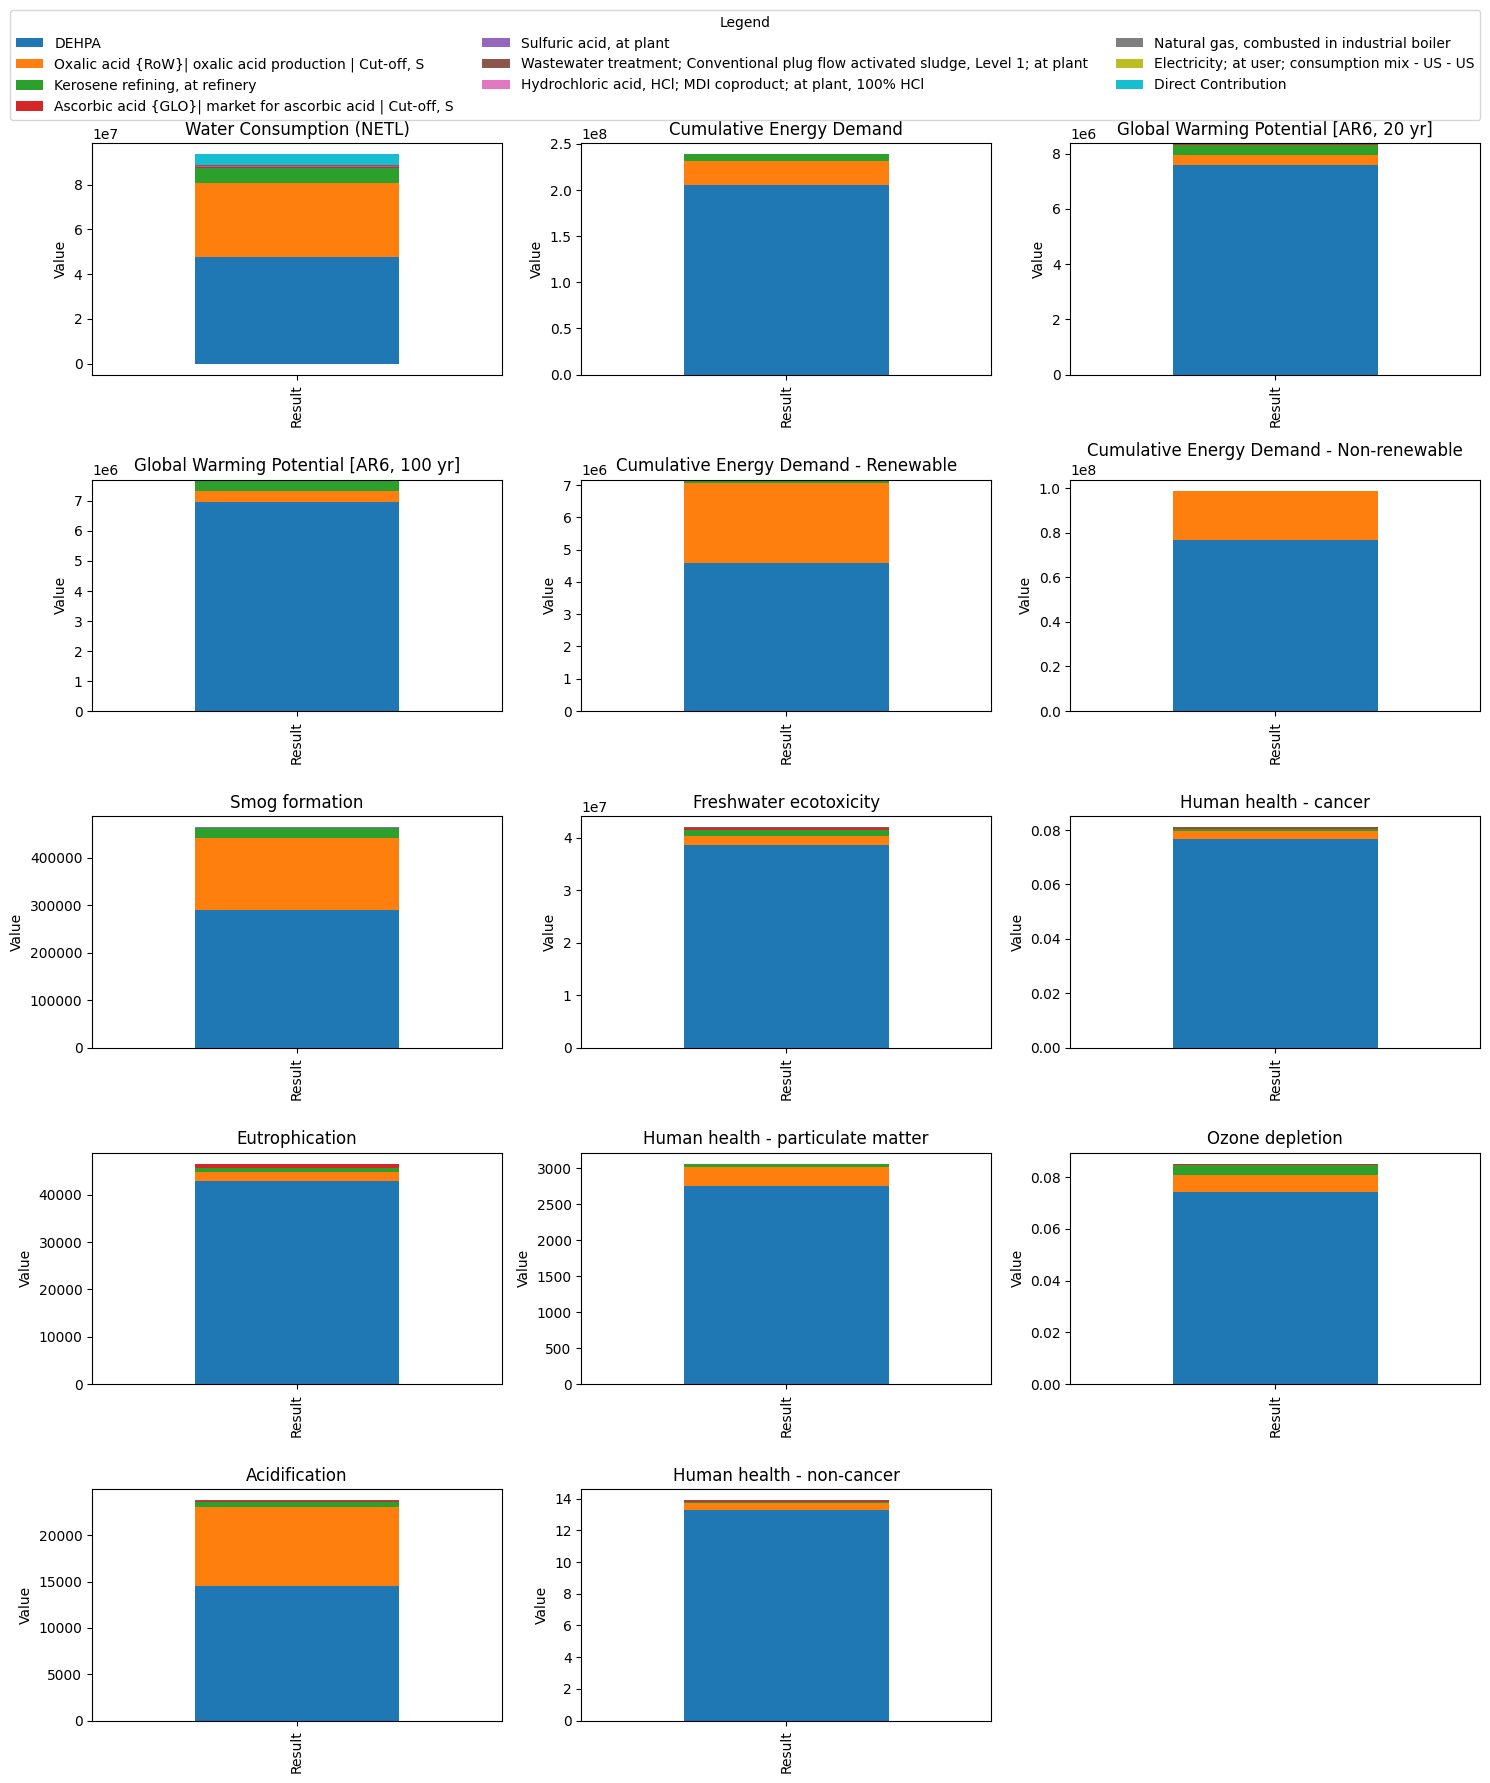

In [17]:
lca_prommis.plot_results.plot_results(result)